In [18]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("aleespinosa/soccer-match-event-dataset")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/aleespinosa/soccer-match-event-dataset/versions/17


Data load

In [351]:
import warnings
warnings.filterwarnings(action='ignore')

from ast import literal_eval

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import shap
from ipywidgets import fixed, interact_manual, widgets
from tqdm import tqdm


In [ ]:
#plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
#sns
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")

In [303]:
df_games = pd.read_csv(path + "/games.csv")
df_features = pd.read_csv(path + "/features.csv")
df_labels = pd.read_csv(path + "/labels.csv")

In [304]:
features = ['start_distance_to_goal-0', 'start_angle_to_goal-0', 'diff_x-0','diff_y-0', 'time_played-0', 'distance_covered-0', 'xdiff_sequence_pre', 'ydiff_sequence_pre', 'xdiff_sequence_post', 'ydiff_sequence_post', 'game_id-0']

In [305]:
# create dataframe
df_features = df_features[features]
df_labels = df_labels['scores']
df = pd.concat([df_labels, df_features], axis = 1)
df.columns = ['scores', 'start_distance_to_goal', 'start_angle_to_goal', 'diff_x','diff_y', 'time_played', 'distance_covered', 'xdiff_sequence_pre', 'ydiff_sequence_pre', 'xdiff_sequence_post', 'ydiff_sequence_post', 'game_id']
df

,scores,start_distance_to_goal,start_angle_to_goal,diff_x,diff_y,time_played,distance_covered,xdiff_sequence_pre,ydiff_sequence_pre,xdiff_sequence_post,ydiff_sequence_post,game_id
0,False,52.500000,0.000000,10.50,-3.40,2.763597,11.036757,NaN,NaN,NaN,NaN,2500089
1,False,42.137394,12.352941,1.05,-20.40,4.761353,20.427004,NaN,NaN,NaN,NaN,2500089
2,False,47.363937,1.720588,8.40,10.20,5.533097,13.213629,11.55,-23.80,19.95,-13.60,2500089
3,False,35.276940,2.393382,-36.75,-1.36,7.707561,36.775156,9.45,-10.20,-27.30,-11.56,2500089
4,False,70.896344,4.632353,-5.25,-6.80,11.614943,8.590838,-28.35,8.84,-33.60,2.04,2500089
...,...,...,...,...,...,...,...,...,...,...,...,...
2462721,True,78.096249,5.123663,-5.25,-1.36,5568.496551,5.423292,-21.00,23.12,-26.25,21.76,2057954
2462722,False,26.806156,1.698529,-1.05,4.76,5570.980334,4.874433,9.45,-4.08,8.40,0.68,2057954
2462723,False,25.717078,2.731900,0.00,0.00,5572.843120,0.000000,4.20,6.12,4.20,6.12,2057954
2462724,True,85.832023,7.357266,-19.95,-8.16,5639.438099,21.554306,-3.15,-2.04,-23.10,-10.20,2057954


In [306]:
print(df_games['competition_id'].unique())

[364 412 426 524 795 102  28]


In [309]:
# competition id list-up
df_games = df_games[(df_games['competition_id'] == 364) |
         (df_games['competition_id'] == 412) |
         (df_games['competition_id'] == 426) |
         (df_games['competition_id'] == 524) |
         (df_games['competition_id'] == 795)
         ]
df_games = df_games[['game_id', 'competition_id']]
df = df[df['game_id'].isin(df_games['game_id'])]

In [310]:
# remove missing values
df.dropna(inplace = True)

<ipython-input-310-ee7e374783b4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace = True)


In [360]:
df_temp = df[df['game_id'].isin(df_games[df_games['competition_id'] == 364]['game_id'])]

언더샘플링 등

In [361]:
df_temp.pop('game_id')
y = df_temp['scores']
X = df_temp[['start_distance_to_goal', 'start_angle_to_goal', 'diff_x','diff_y', 'time_played', 'distance_covered', 'xdiff_sequence_pre', 'ydiff_sequence_pre', 'xdiff_sequence_post', 'ydiff_sequence_post']]

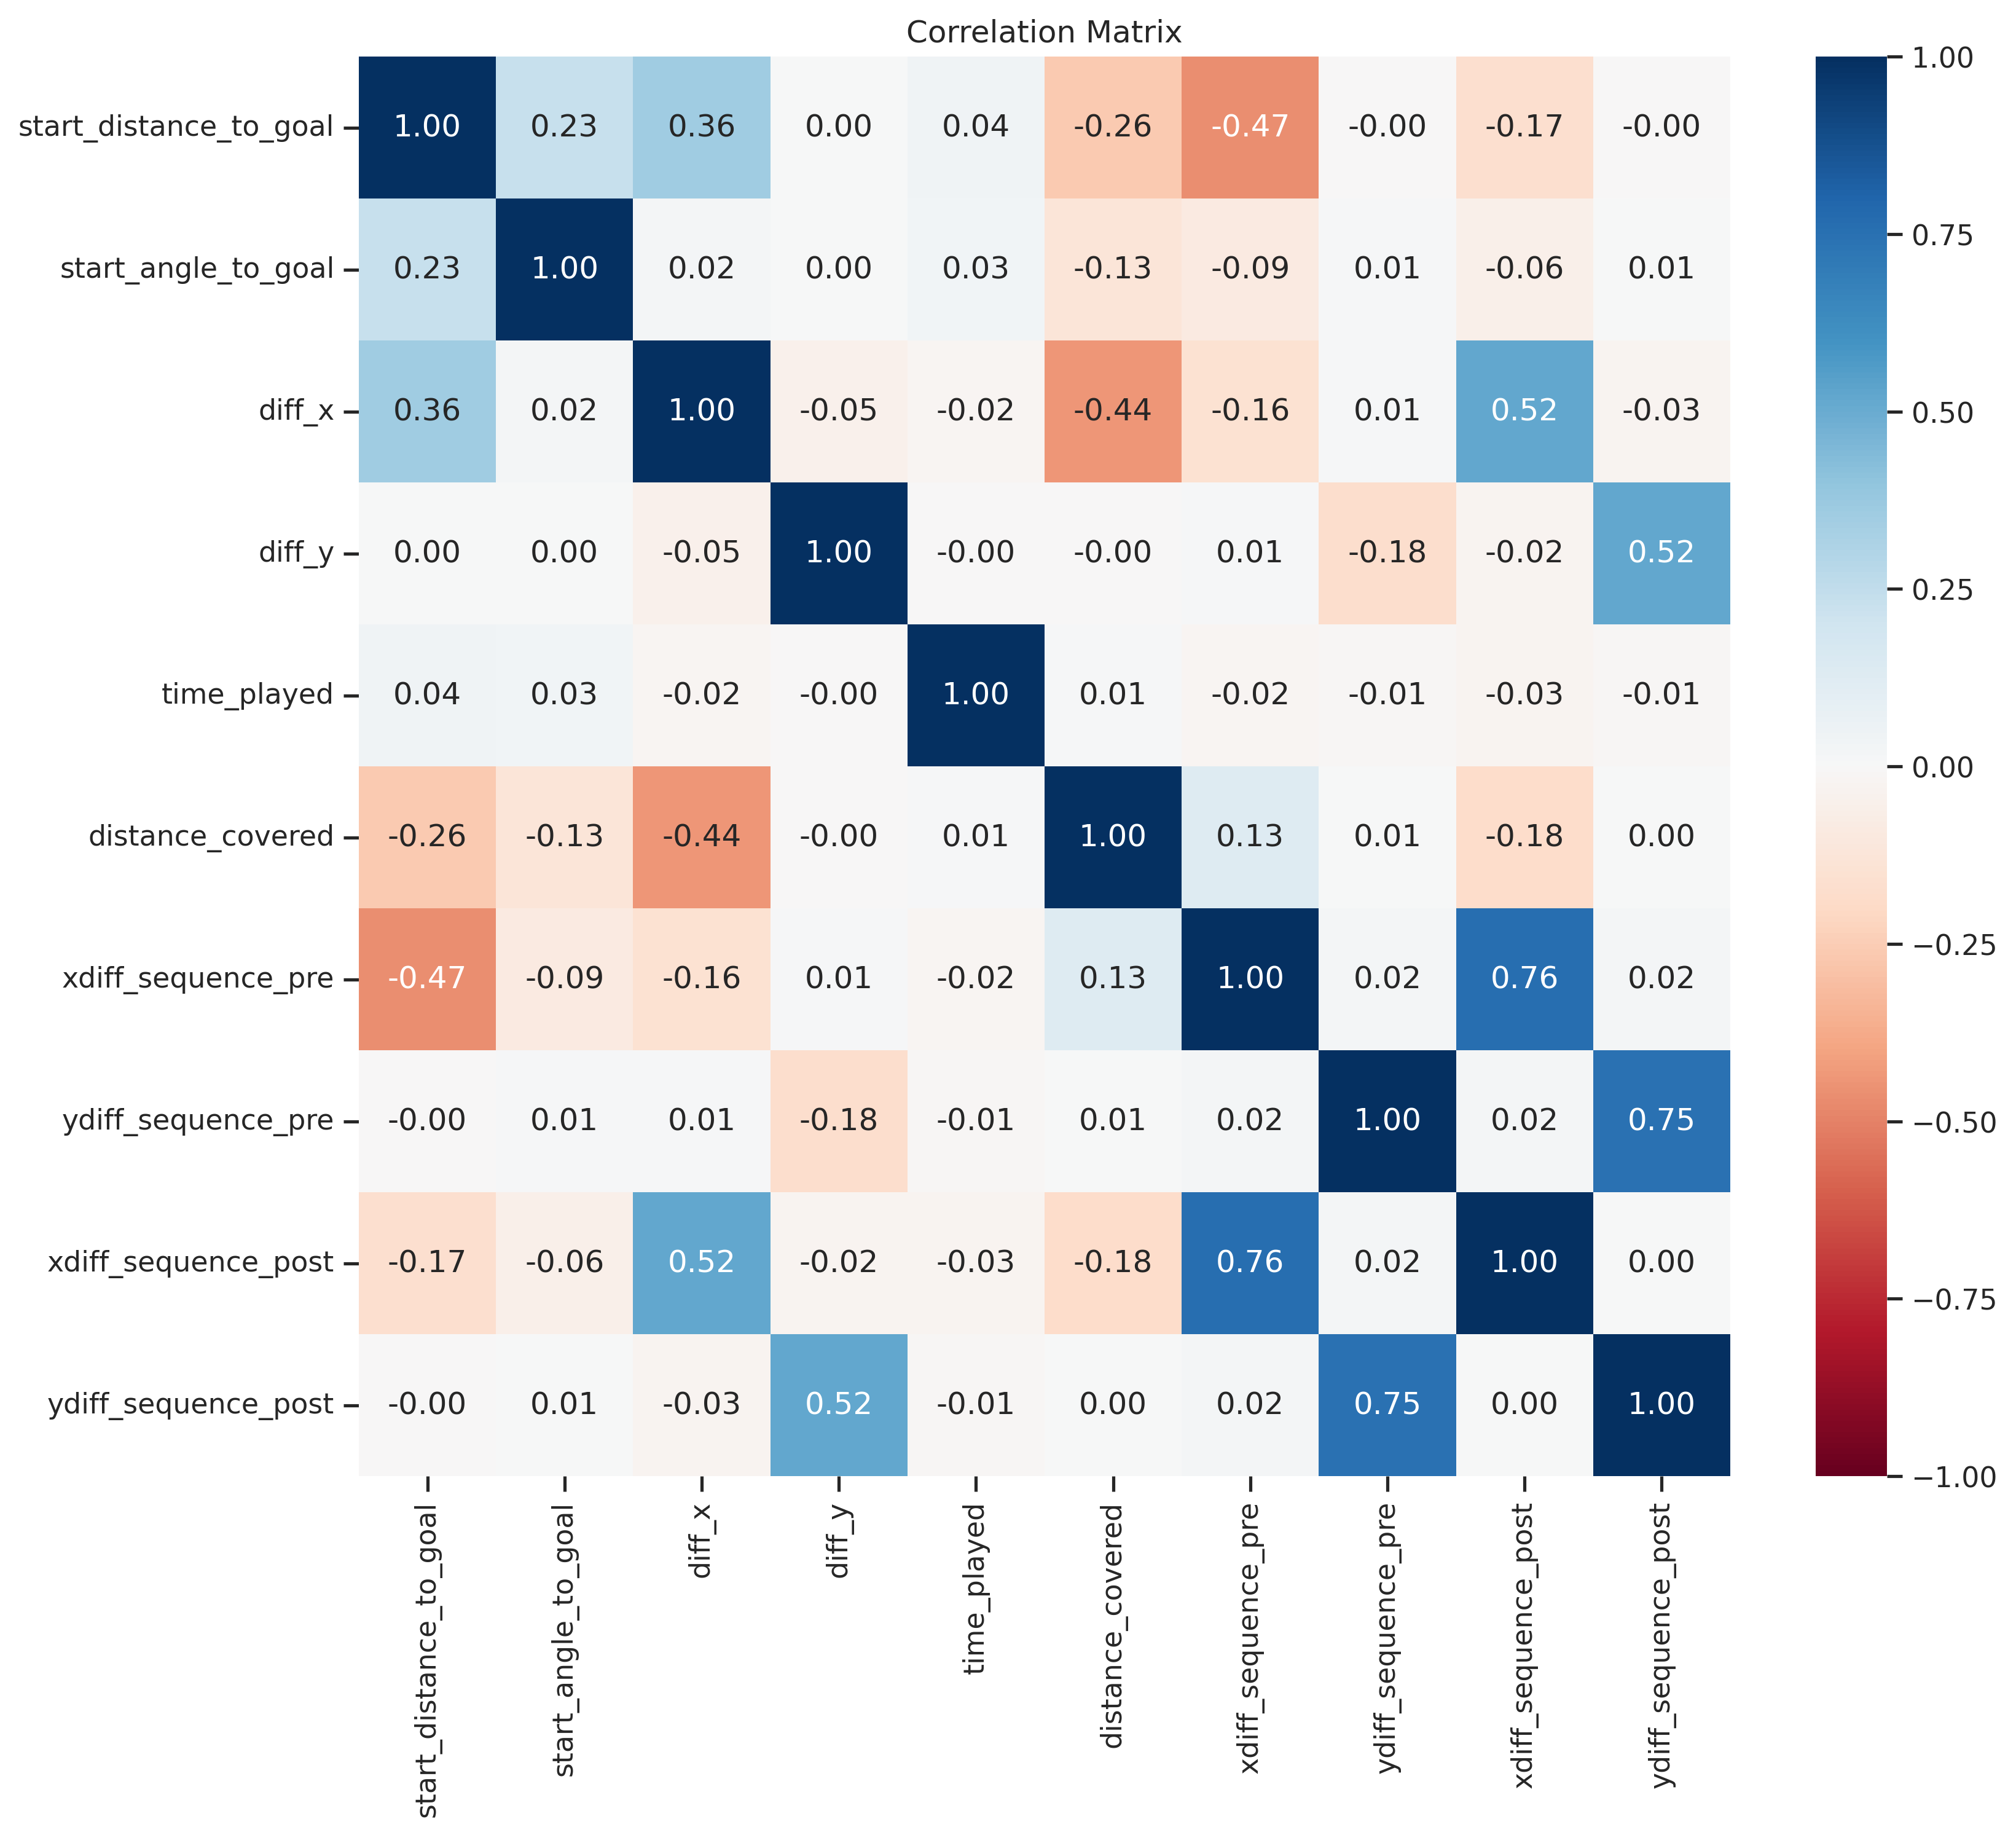

In [ ]:
# Correlation Graph 
def plot_correlation_matrix(data, features):
    plt.figure(figsize=(12, 10))
    corr = data.corr()  # correlation between feature
    sns.heatmap(corr, annot=True, fmt=".2f", cmap='RdBu', cbar=True, center = 0, vmax=1, vmin=-1)
    plt.title("Correlation Matrix")
    plt.show()

# Correlation Graph
plot_correlation_matrix(X, X.columns)

In [ ]:
# undersampling because of bias of data
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X, y = rus.fit_resample(X, y)

In [315]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [316]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

모델링

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# LGBMClassifier, LogisticRegression 

# Define Model
models = {
    'XGBoost': XGBClassifier(eval_metric='logloss', use_label_encoder=False, n_estimators=100, max_depth=3, random_state = 42),
    'LightGBM': LGBMClassifier(n_estimators=100, max_depth=10, random_state = 42),
    'Random Forest': RandomForestClassifier(n_estimators=100,
                                            # max_depth=10,
                                            random_state = 42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state = 42)}



현재 모델 : XGBoost


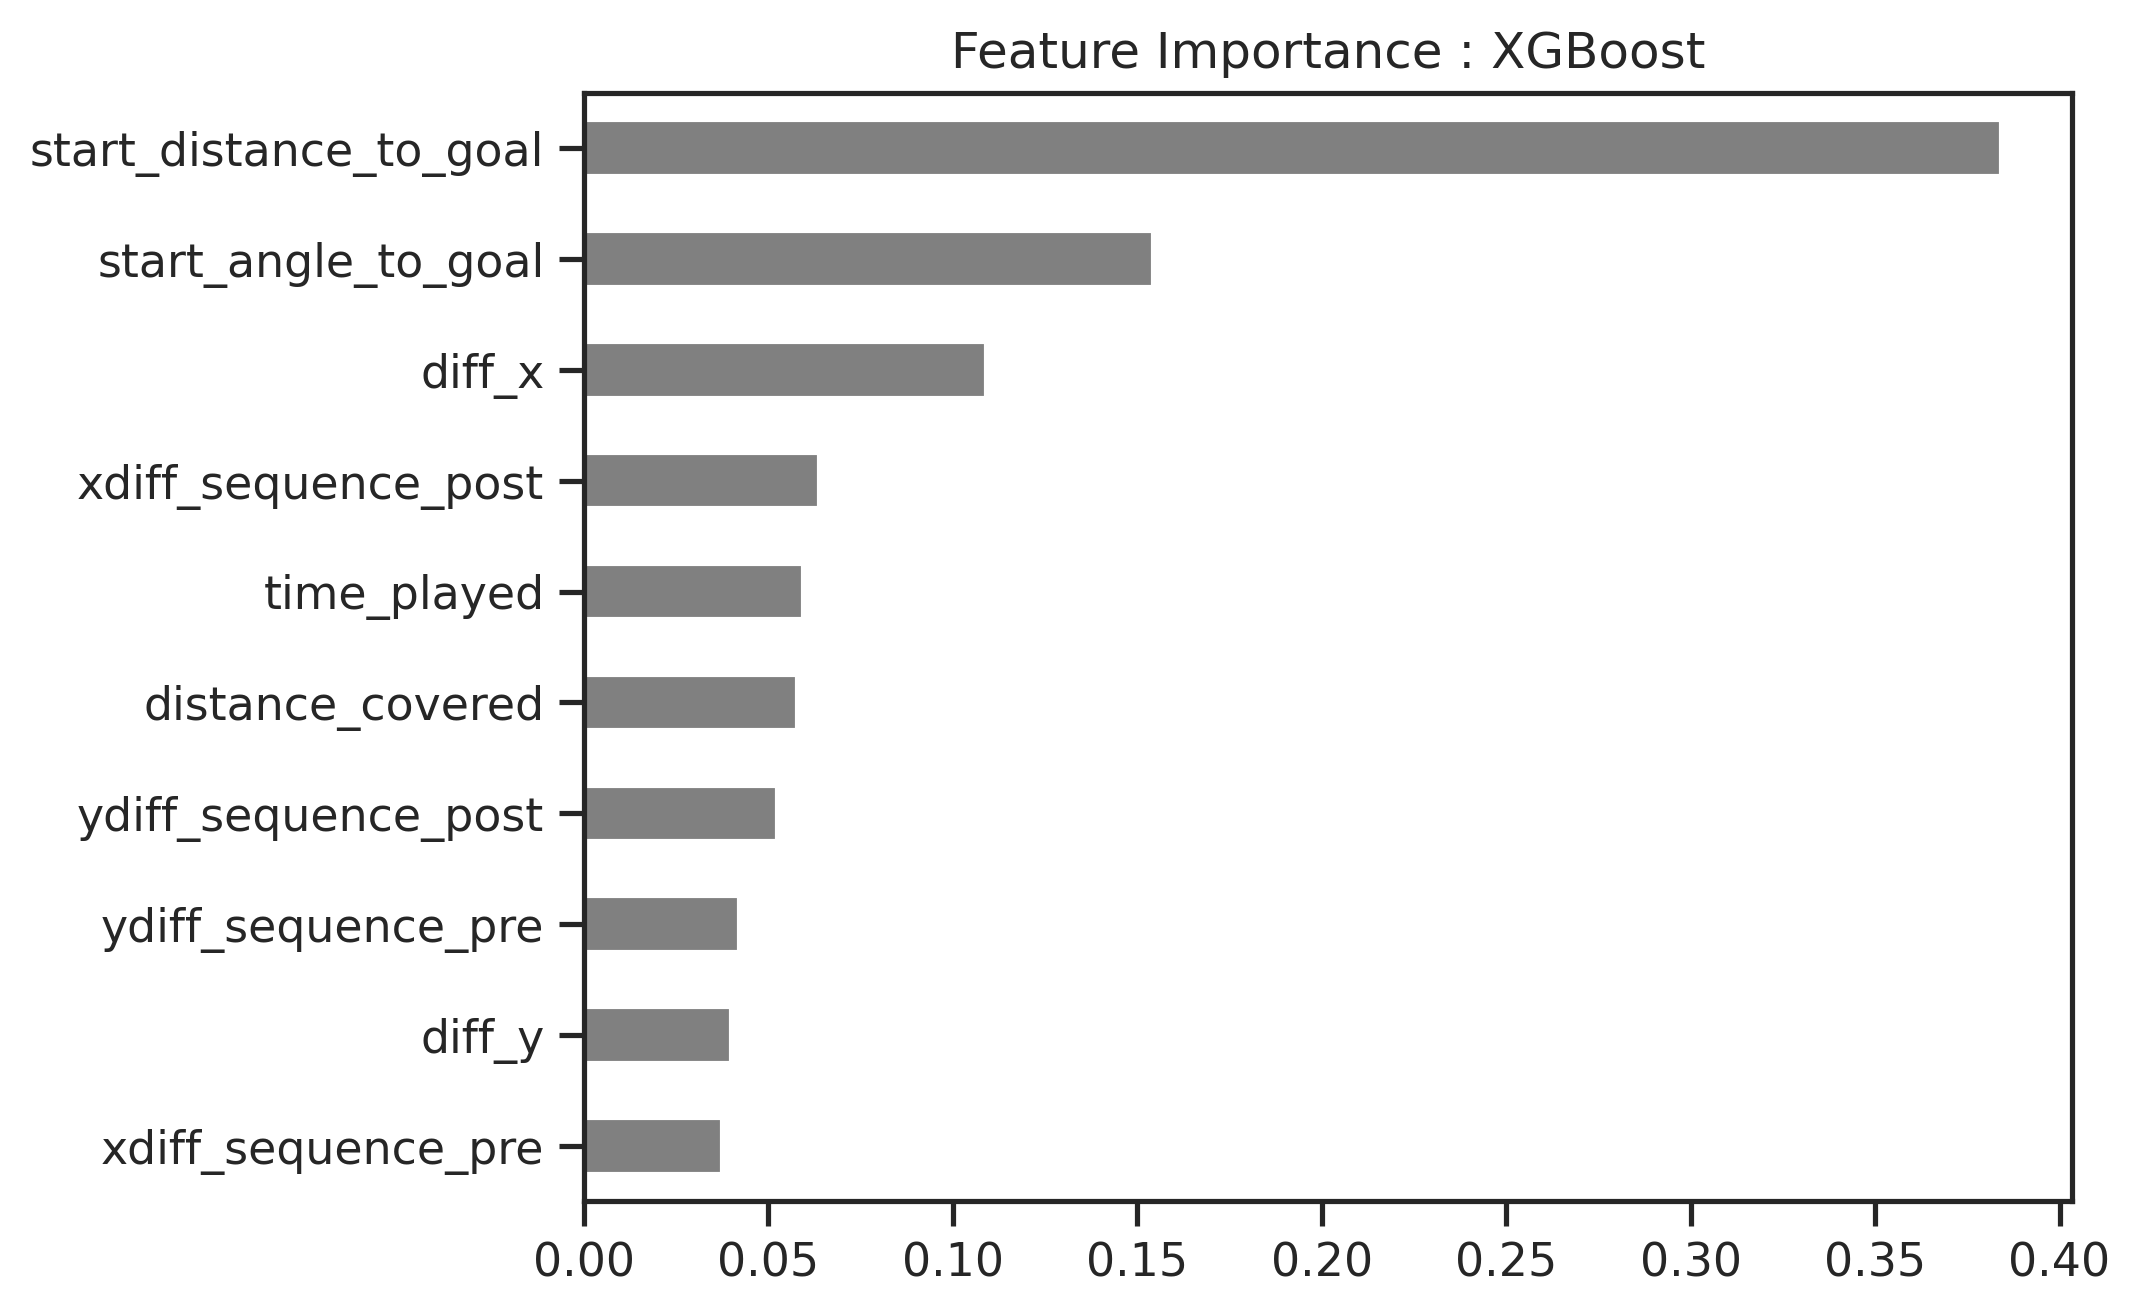

현재 모델 : LightGBM
[LightGBM] [Info] Number of positive: 6040, number of negative: 6040
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2464
[LightGBM] [Info] Number of data points in the train set: 12080, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


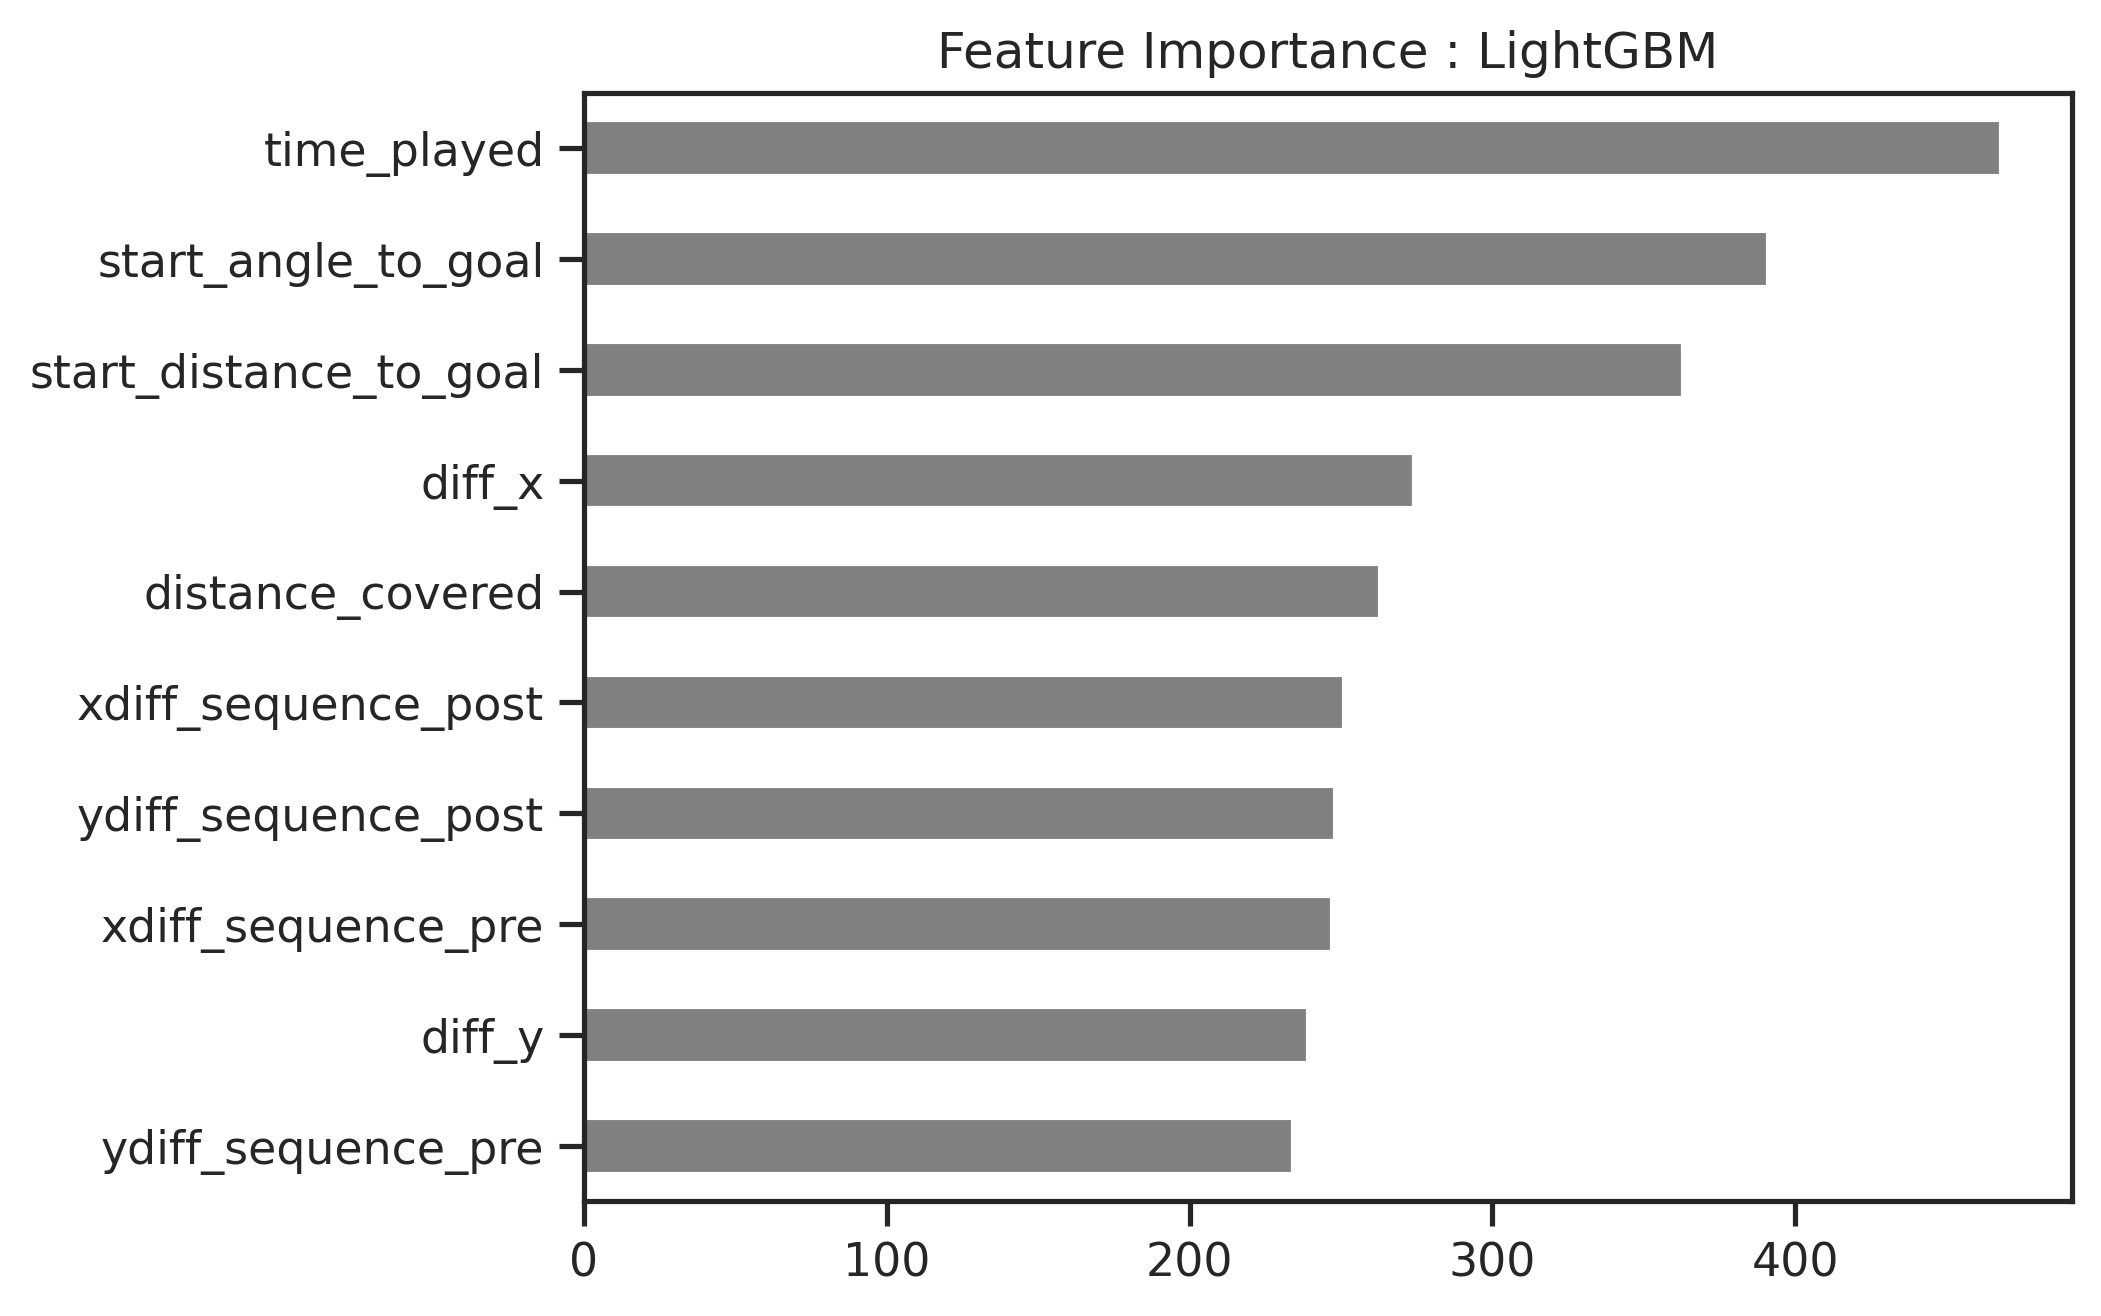

현재 모델 : Logistic Regression
현재 모델 : Random Forest


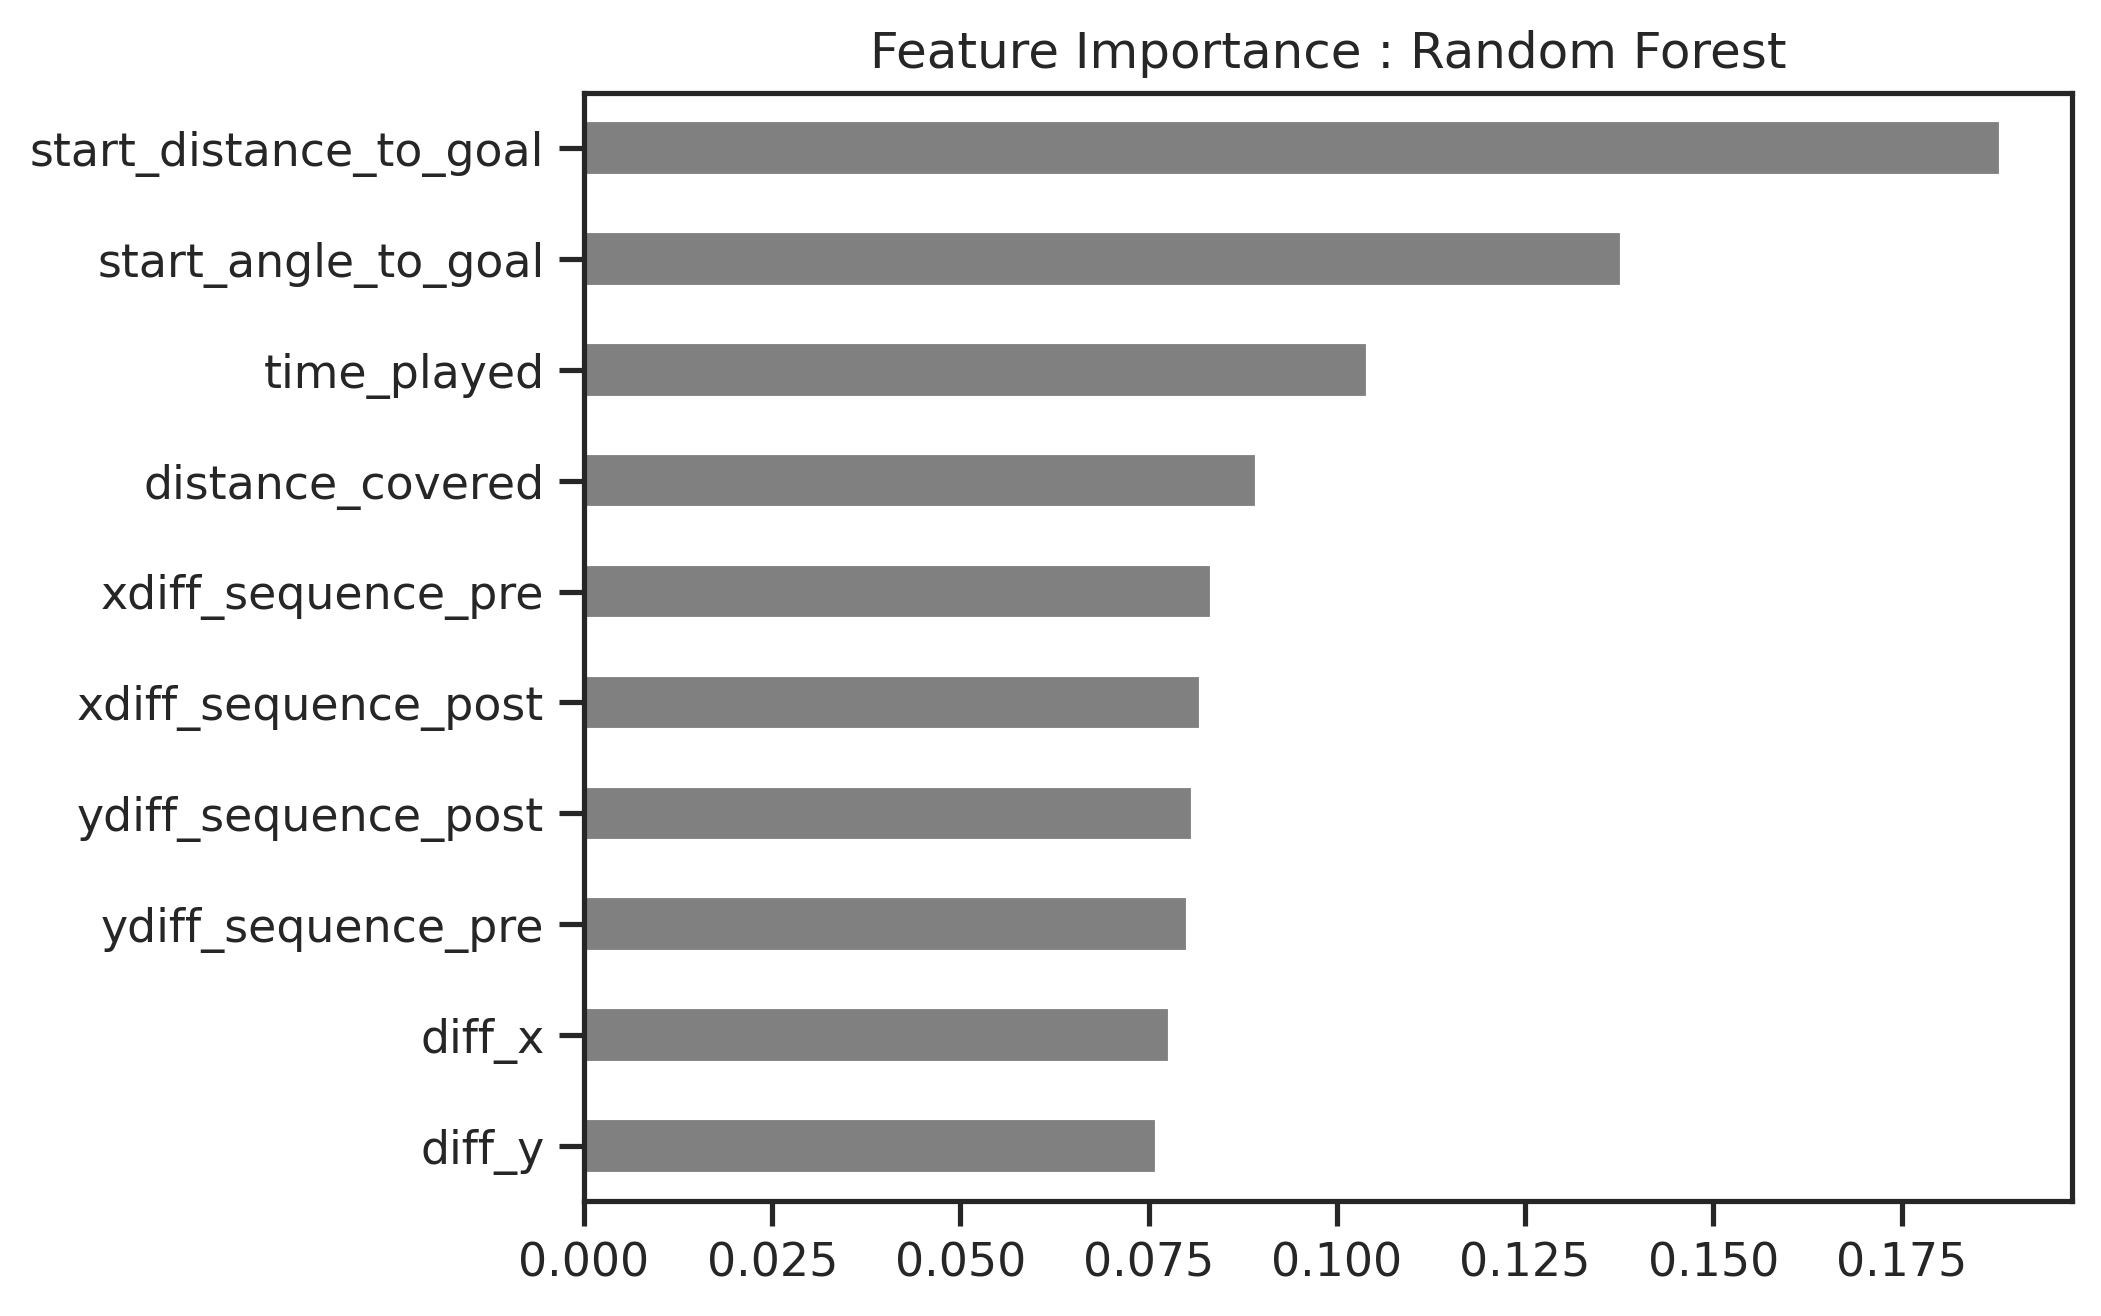

In [ ]:
# Checking feature importance 
for model_name, model in models.items():
    try:
        print(f'Current Model : {model_name}')
        model.fit(X_train, y_train)
        importances = pd.Series(model.feature_importances_, index=X.columns)
        importances.sort_values(ascending=True).plot(kind='barh', color = 'grey')
        plt.title(f'Feature Importance : {model_name}')
        plt.show()
    except: #Logistic Regression can't view feature importance.
        pass


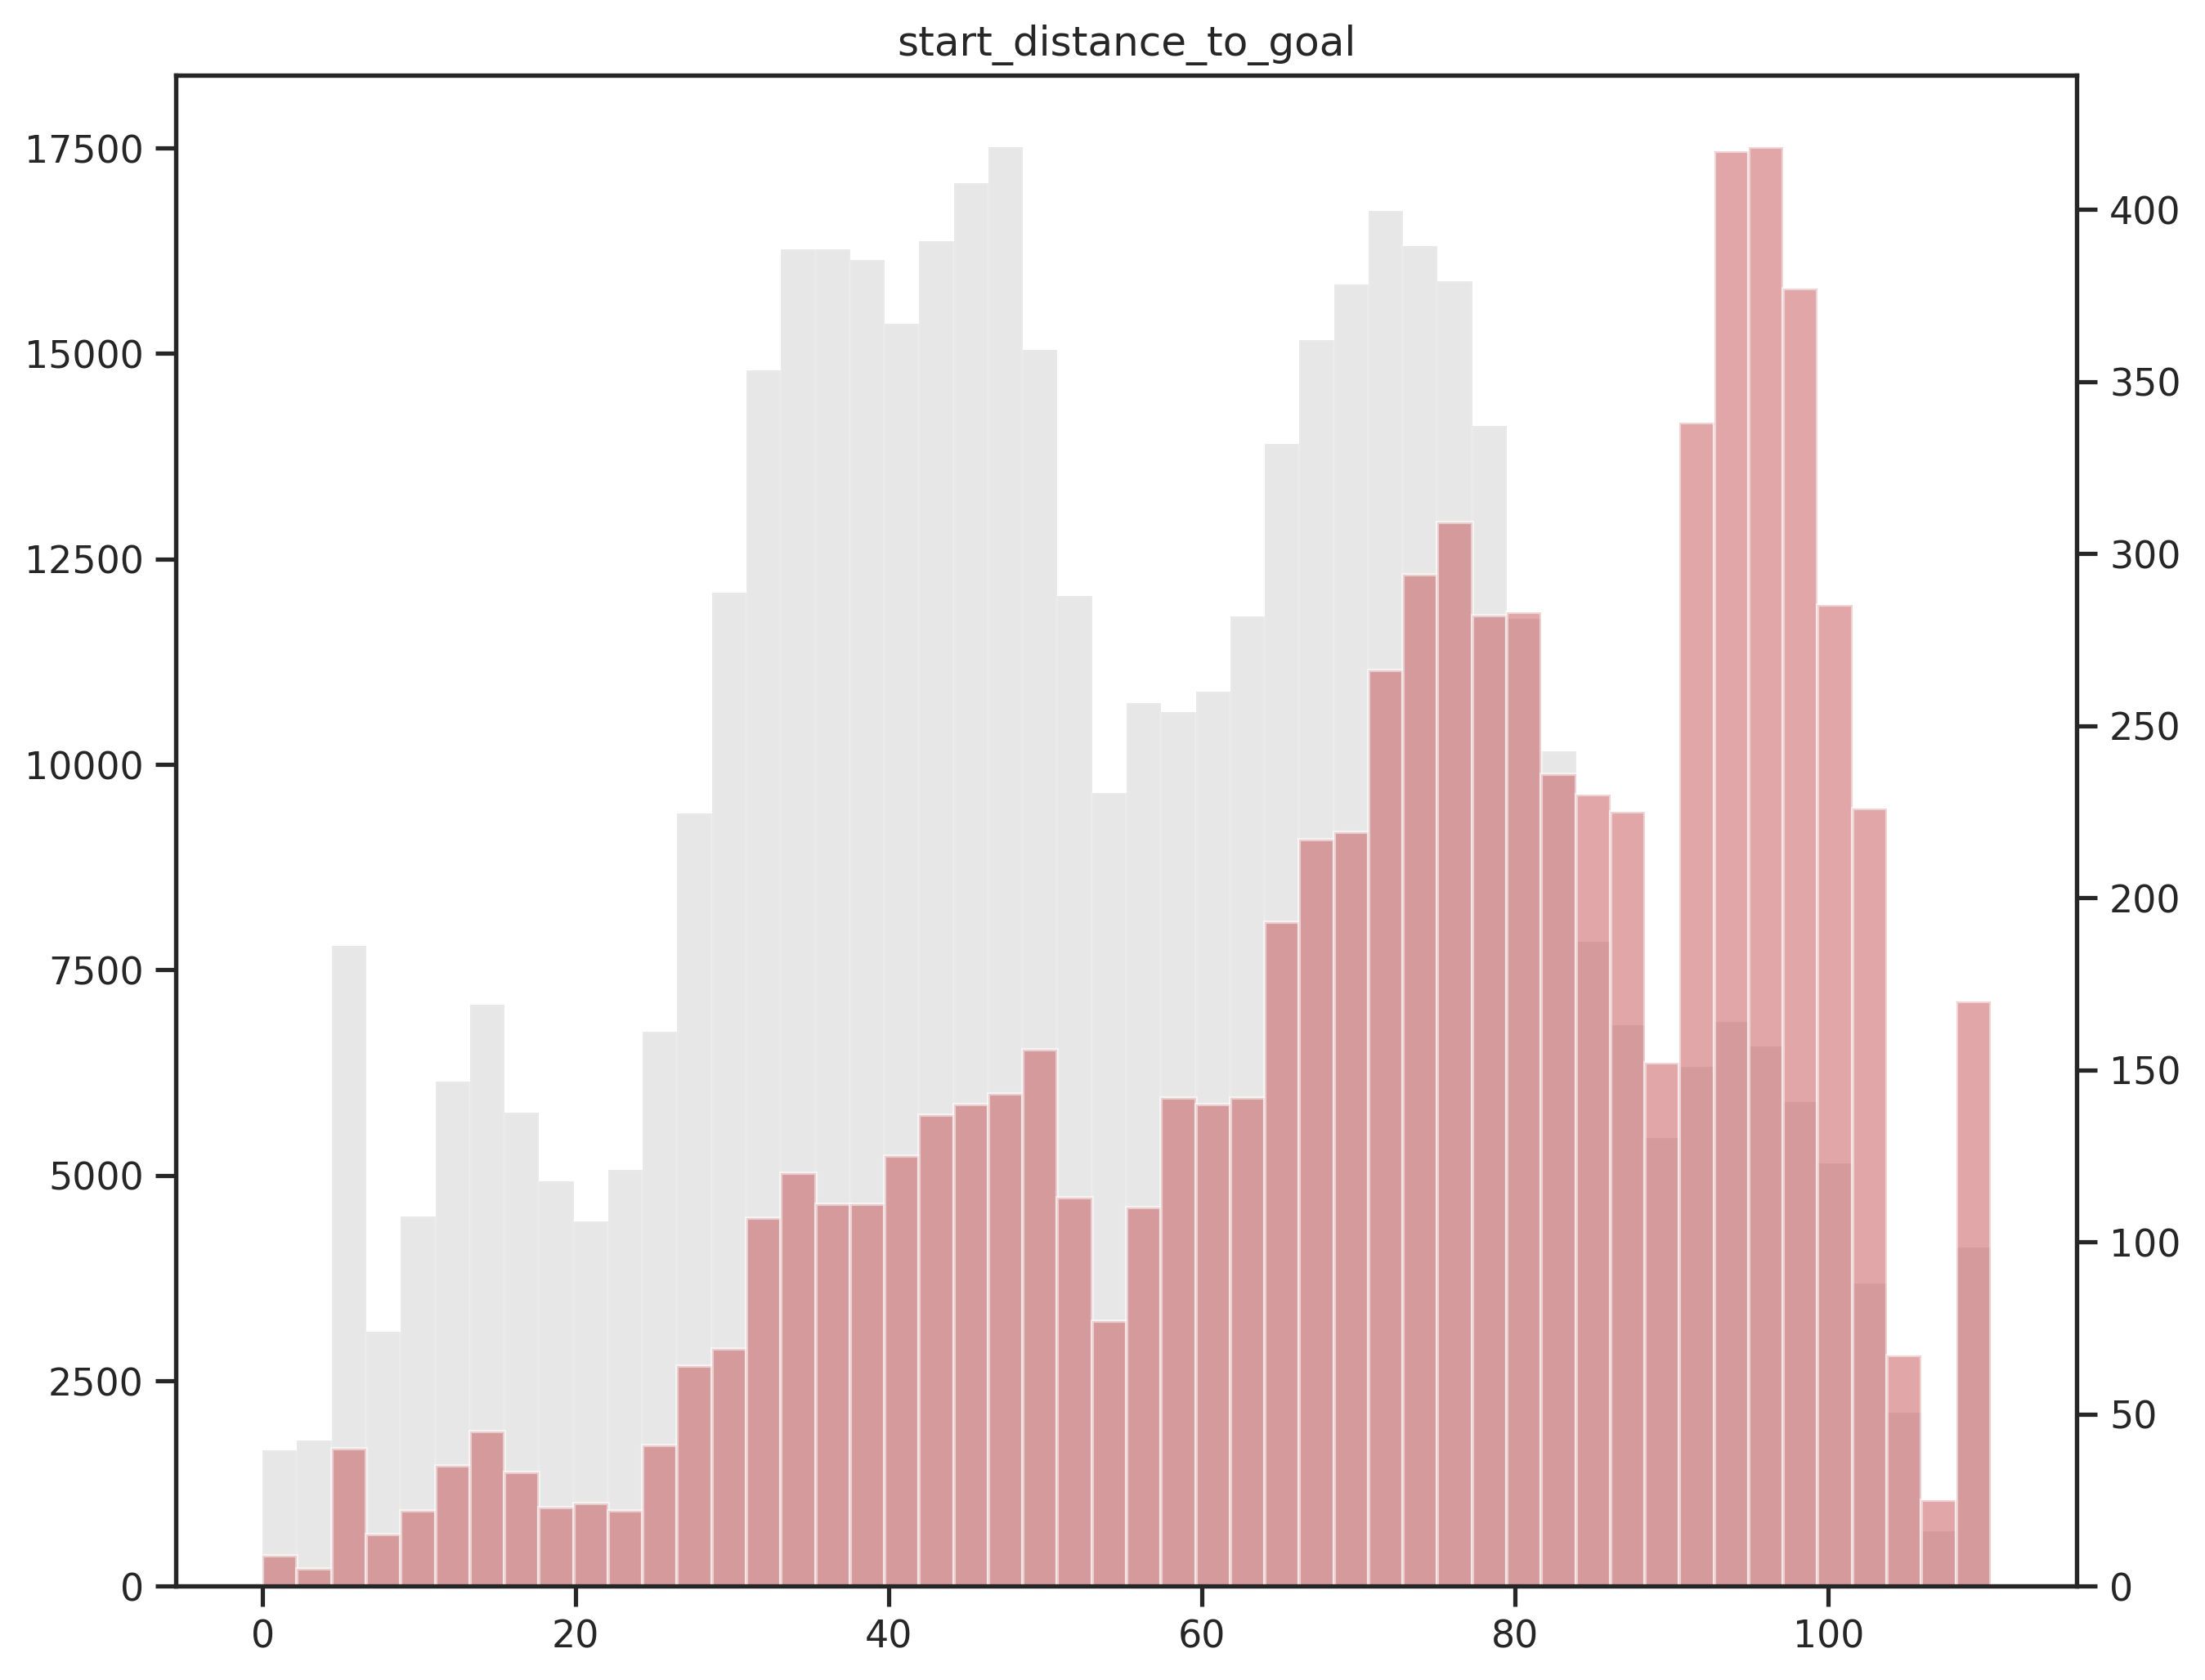

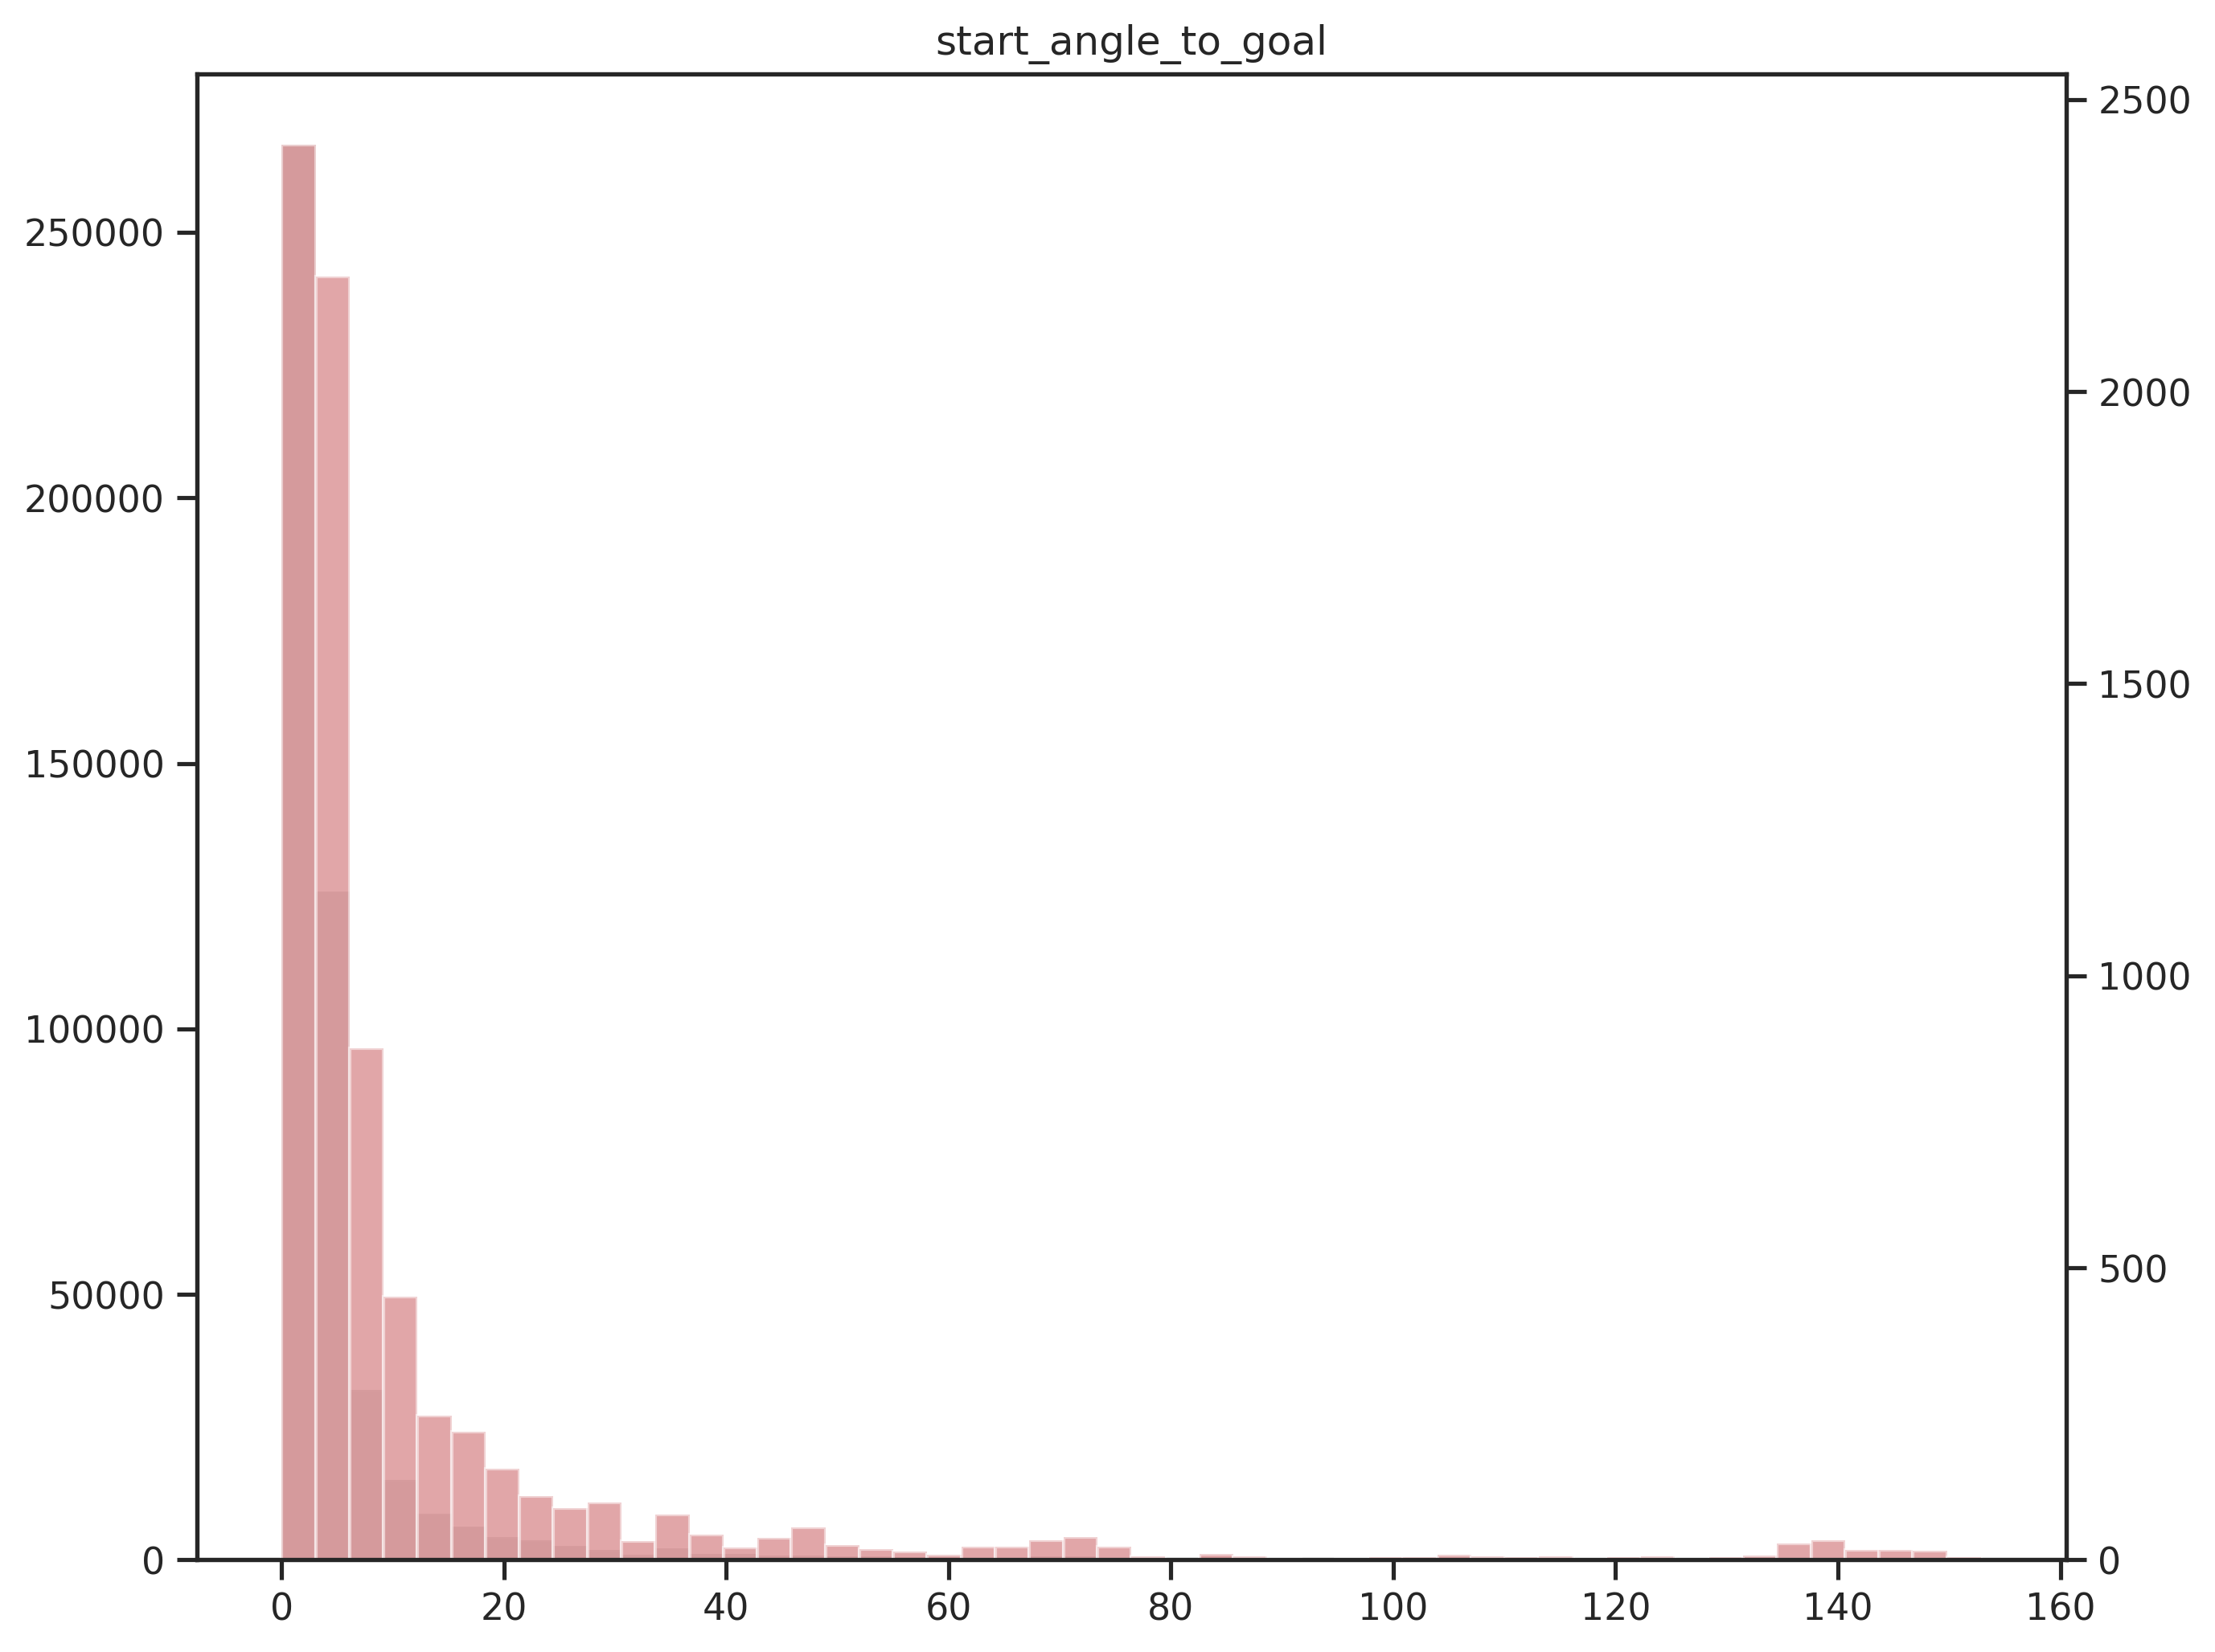

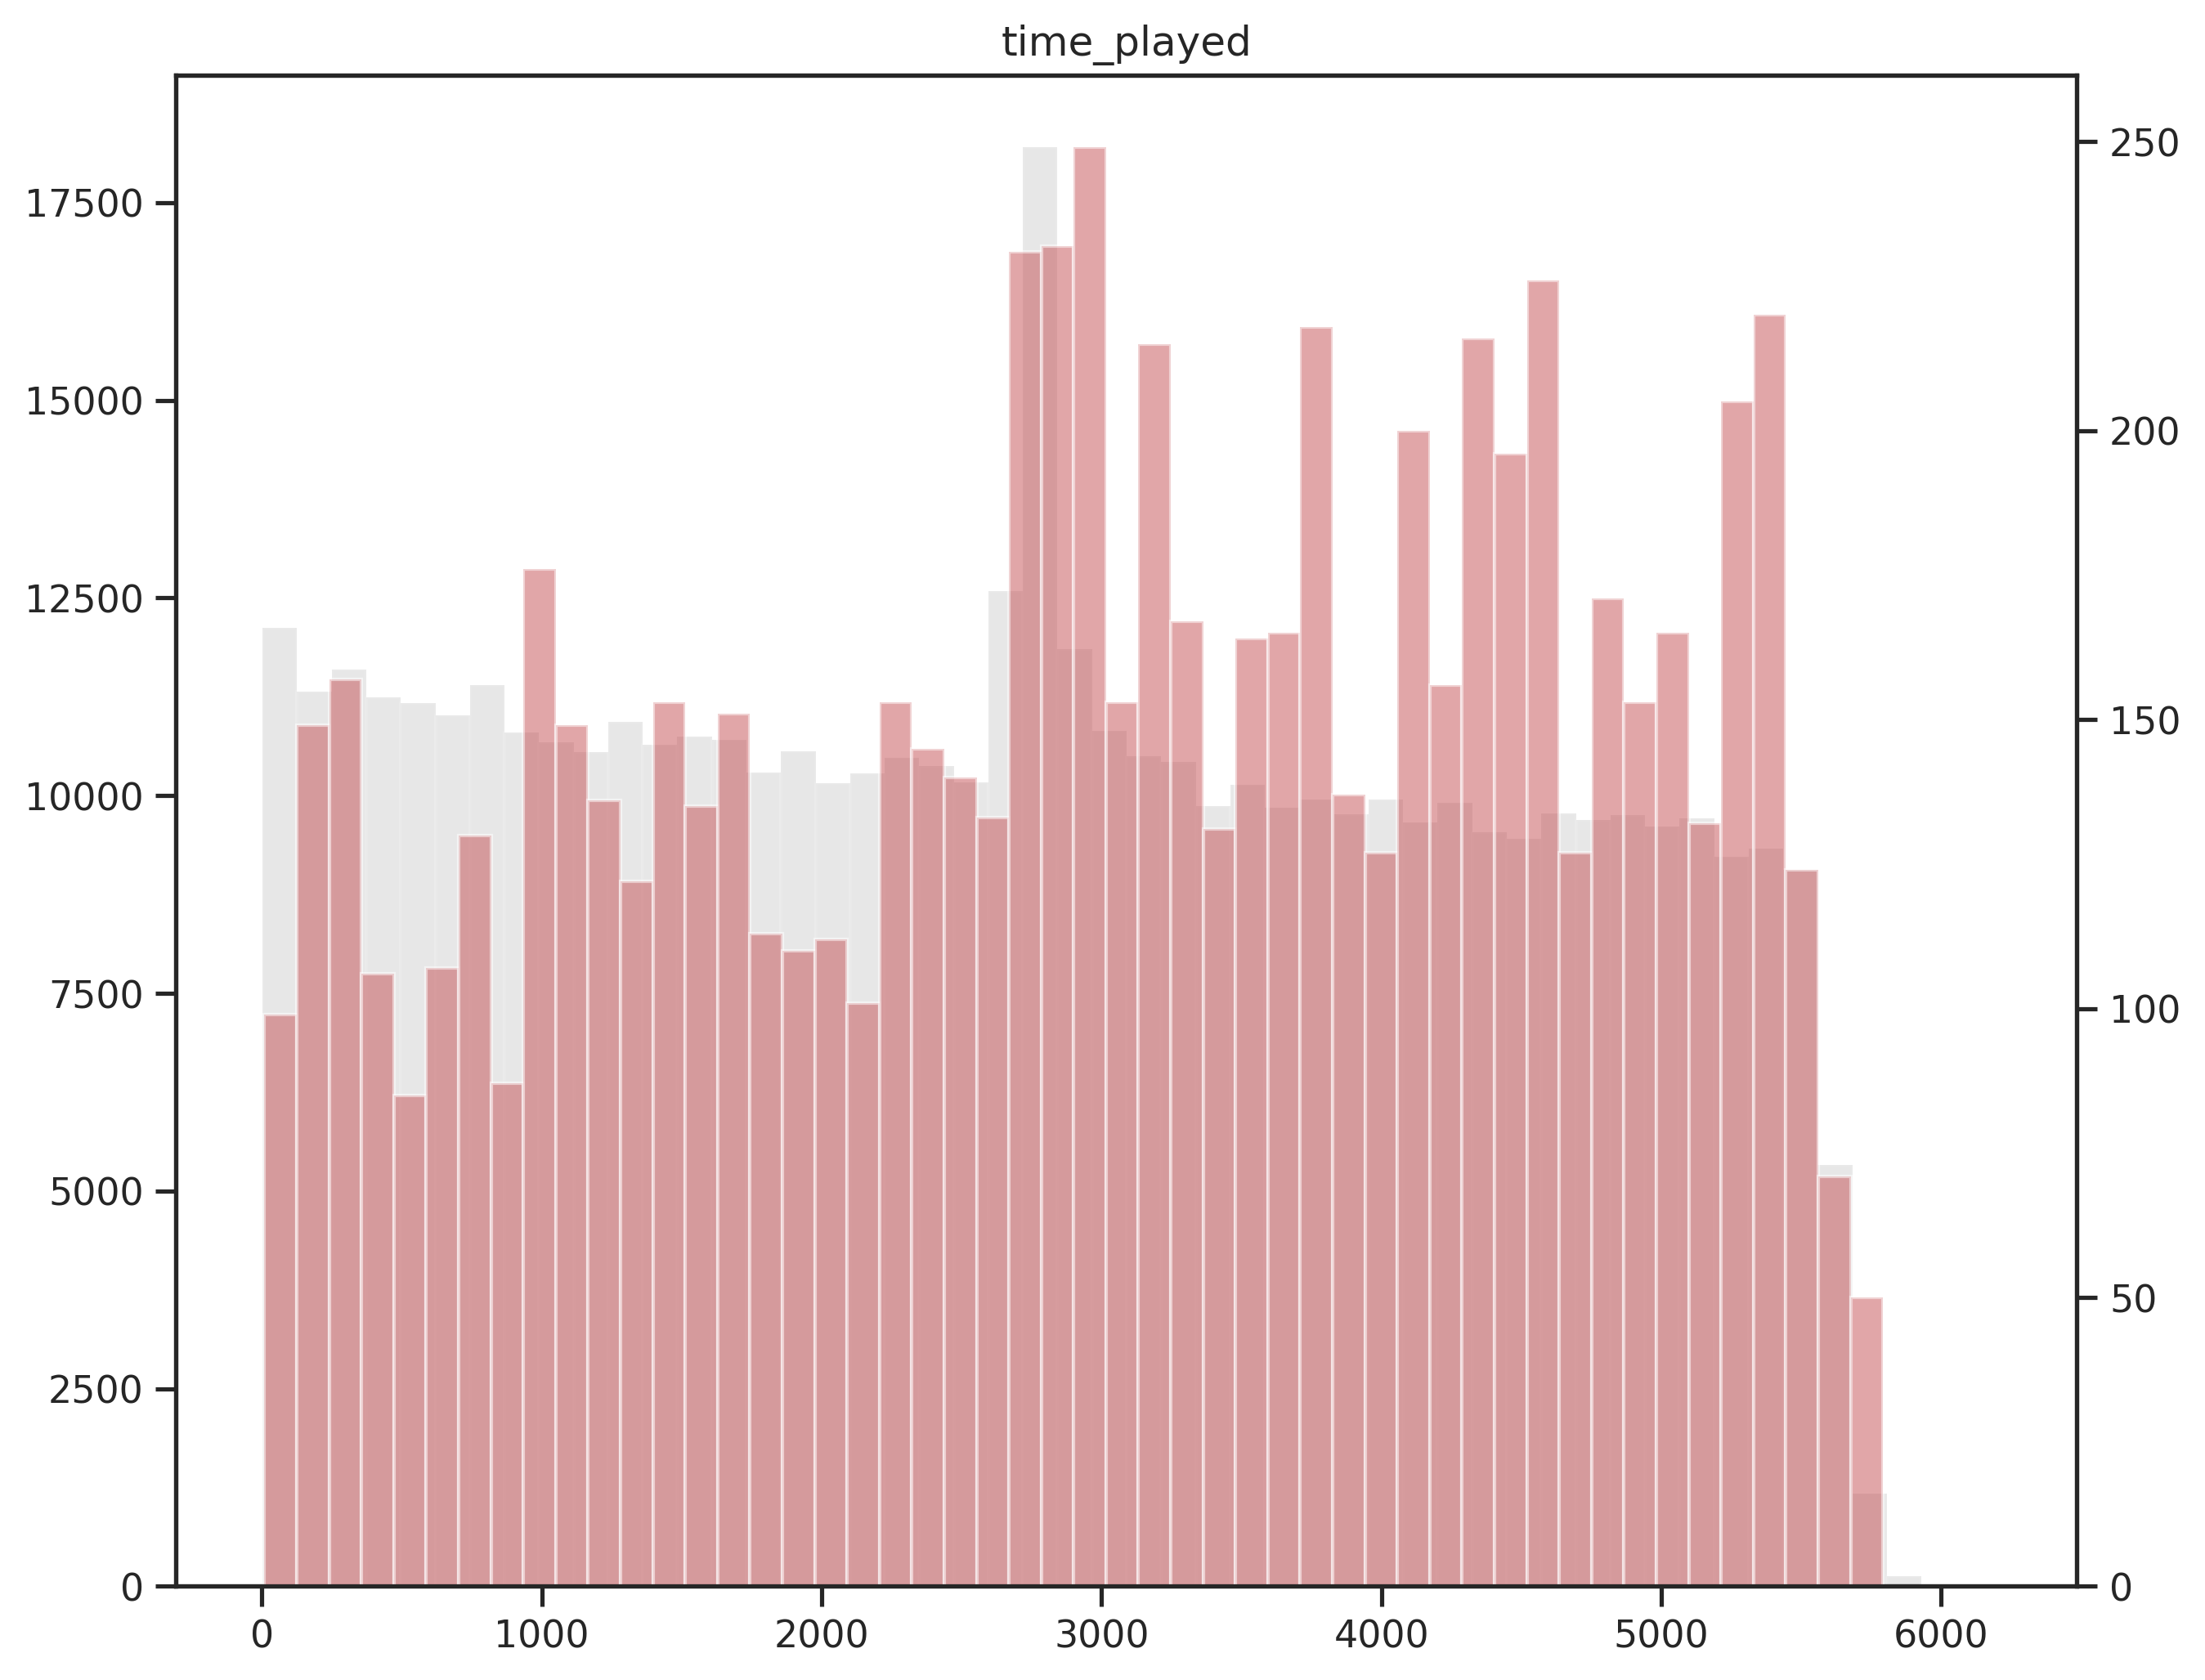

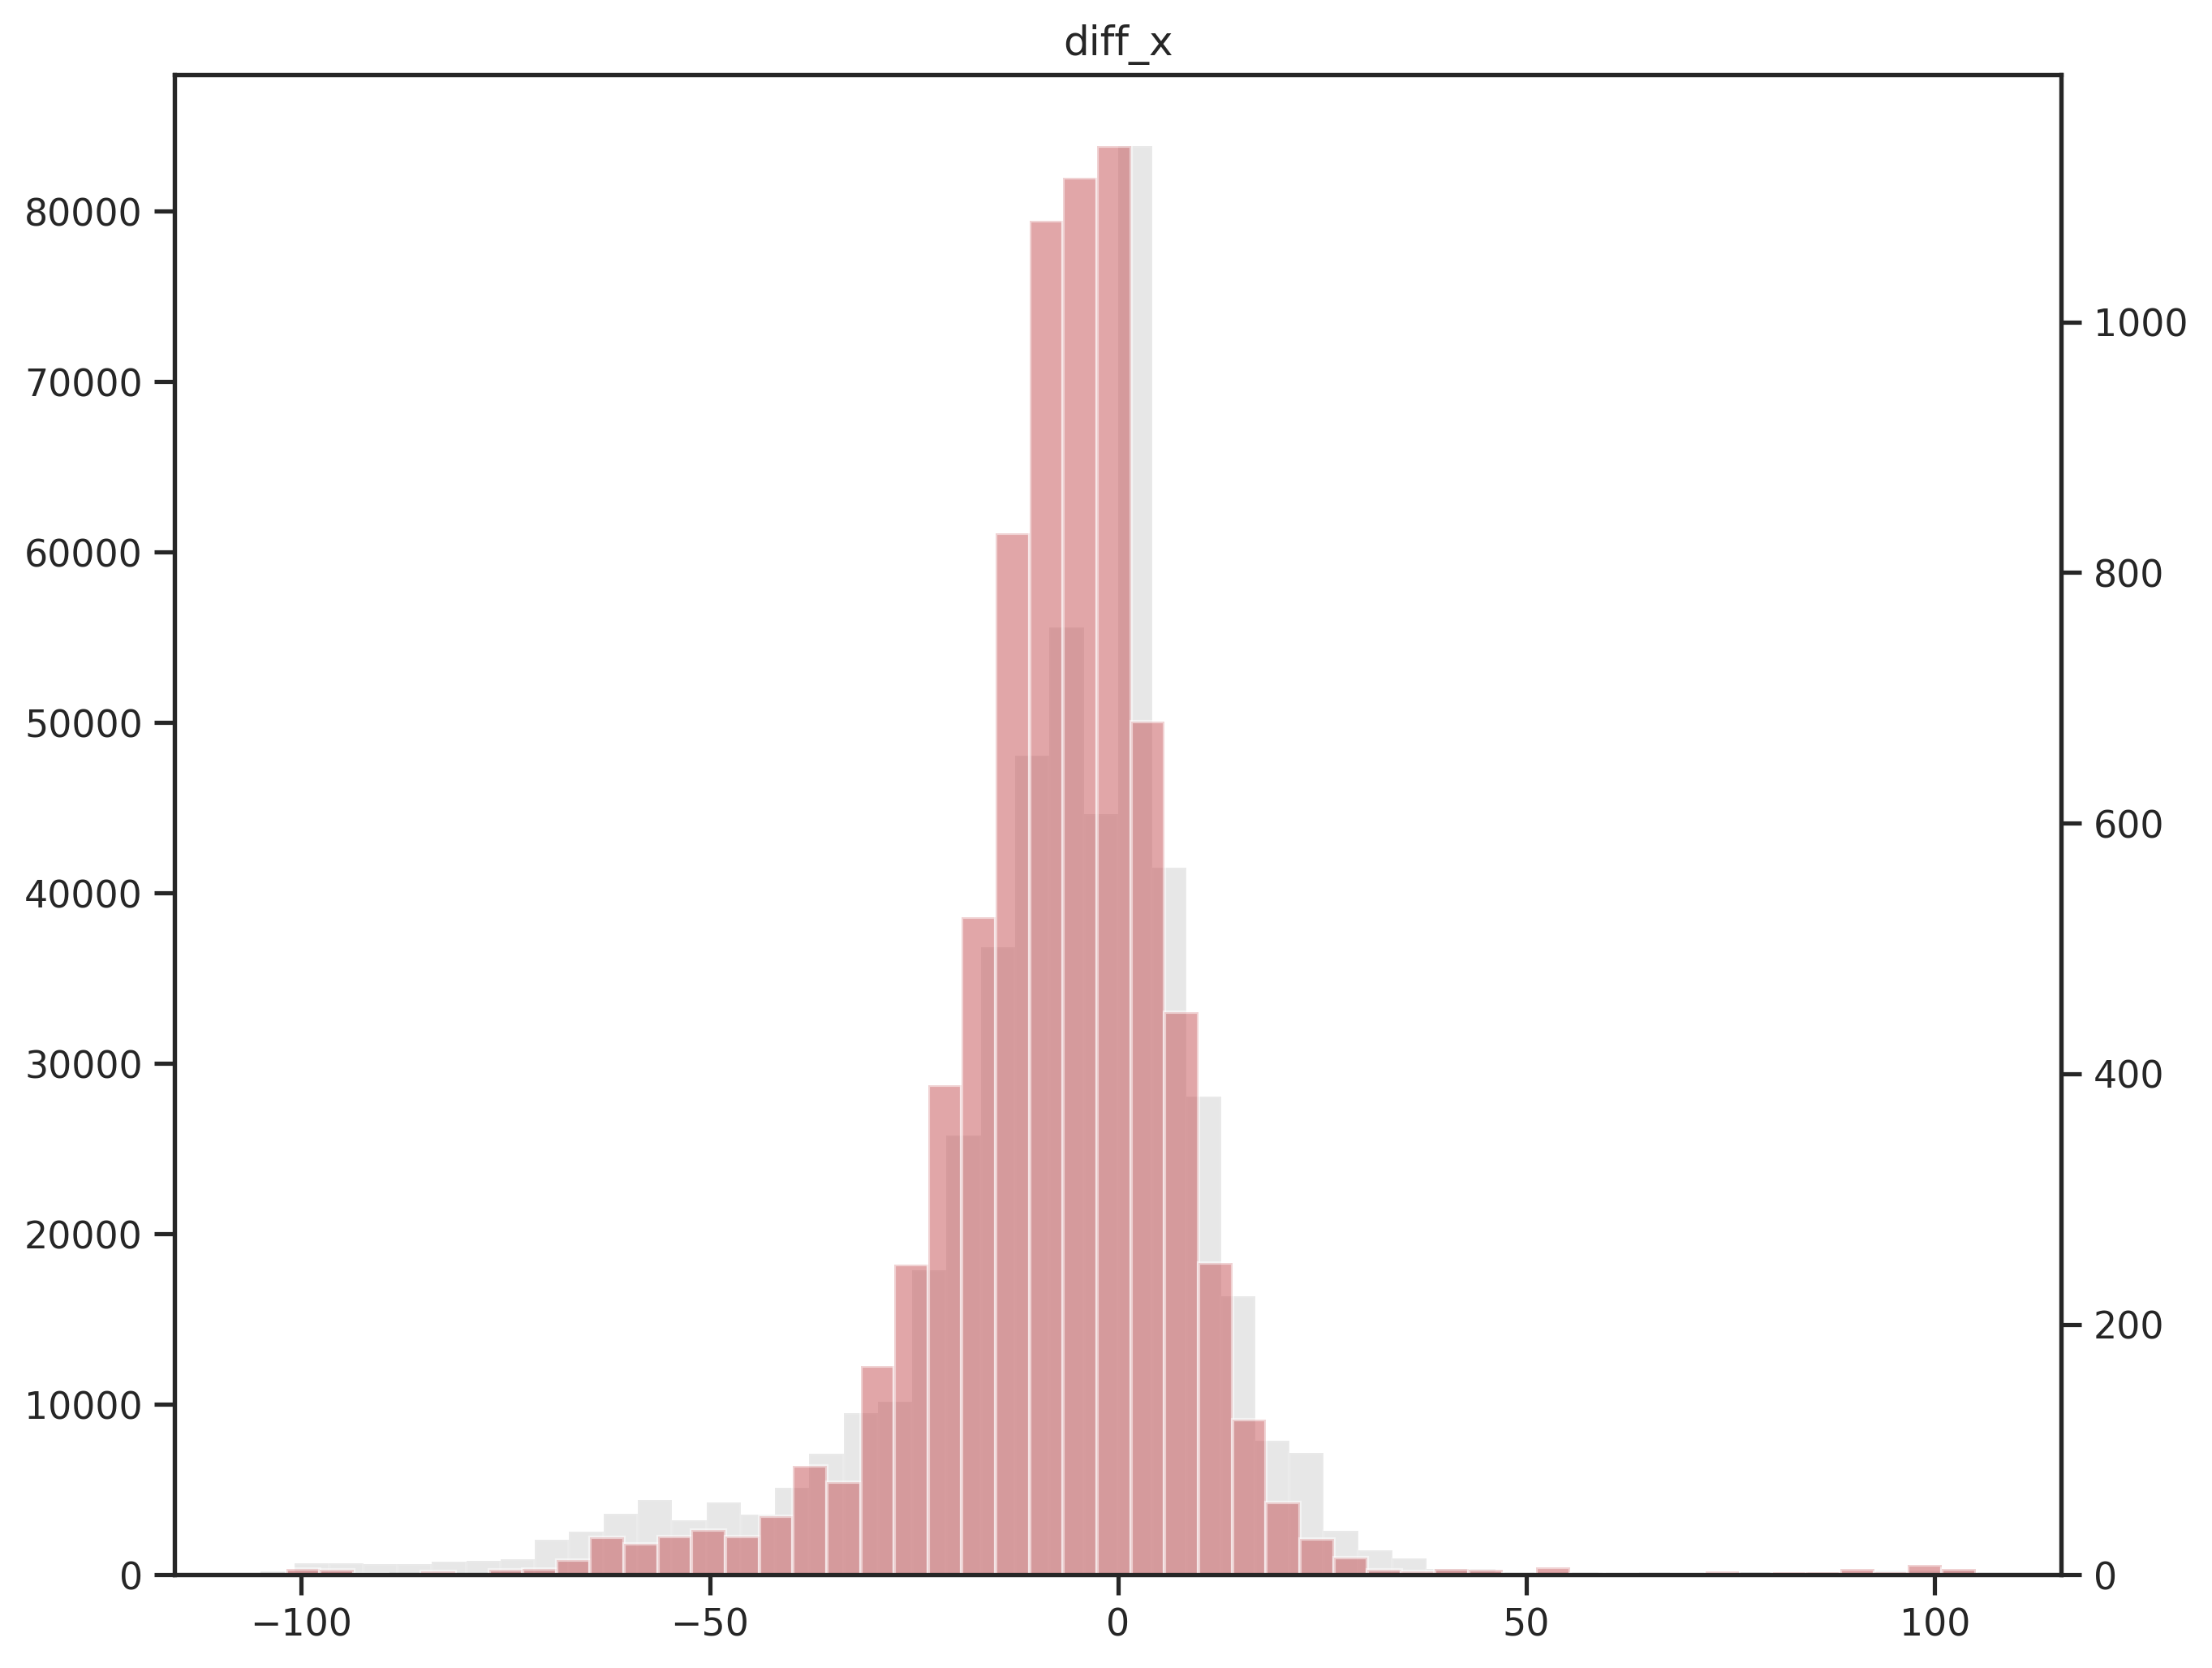

In [ ]:
# Variables that record top 4 between models that have more than 2 features
df_importance_ = df_temp[df_temp['scores']==True][['start_distance_to_goal', 'start_angle_to_goal', 'time_played', 'diff_x']]
for col in df_importance_.columns:
    fig, ax1 = plt.subplots(figsize=(10, 8))
    ax1.hist(df_temp[col], bins = 50,
             alpha = 0.1, color = 'k') # formal distribution
    ax2 = ax1.twinx()
    ax2.hist(df_importance_[col], bins = 50,
             alpha = 0.5, color = 'r') # score = distribution of True
    plt.title(col)
    plt.show()

# As a result, when bigger "start_distance_to_goal", higher the probability of goal.
# Otherwise, other feature is not much diffenent between goal situation and other playtime.
# That shows not only few feature driven to goal.

[LightGBM] [Info] Number of positive: 6040, number of negative: 6040
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2464
[LightGBM] [Info] Number of data points in the train set: 12080, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


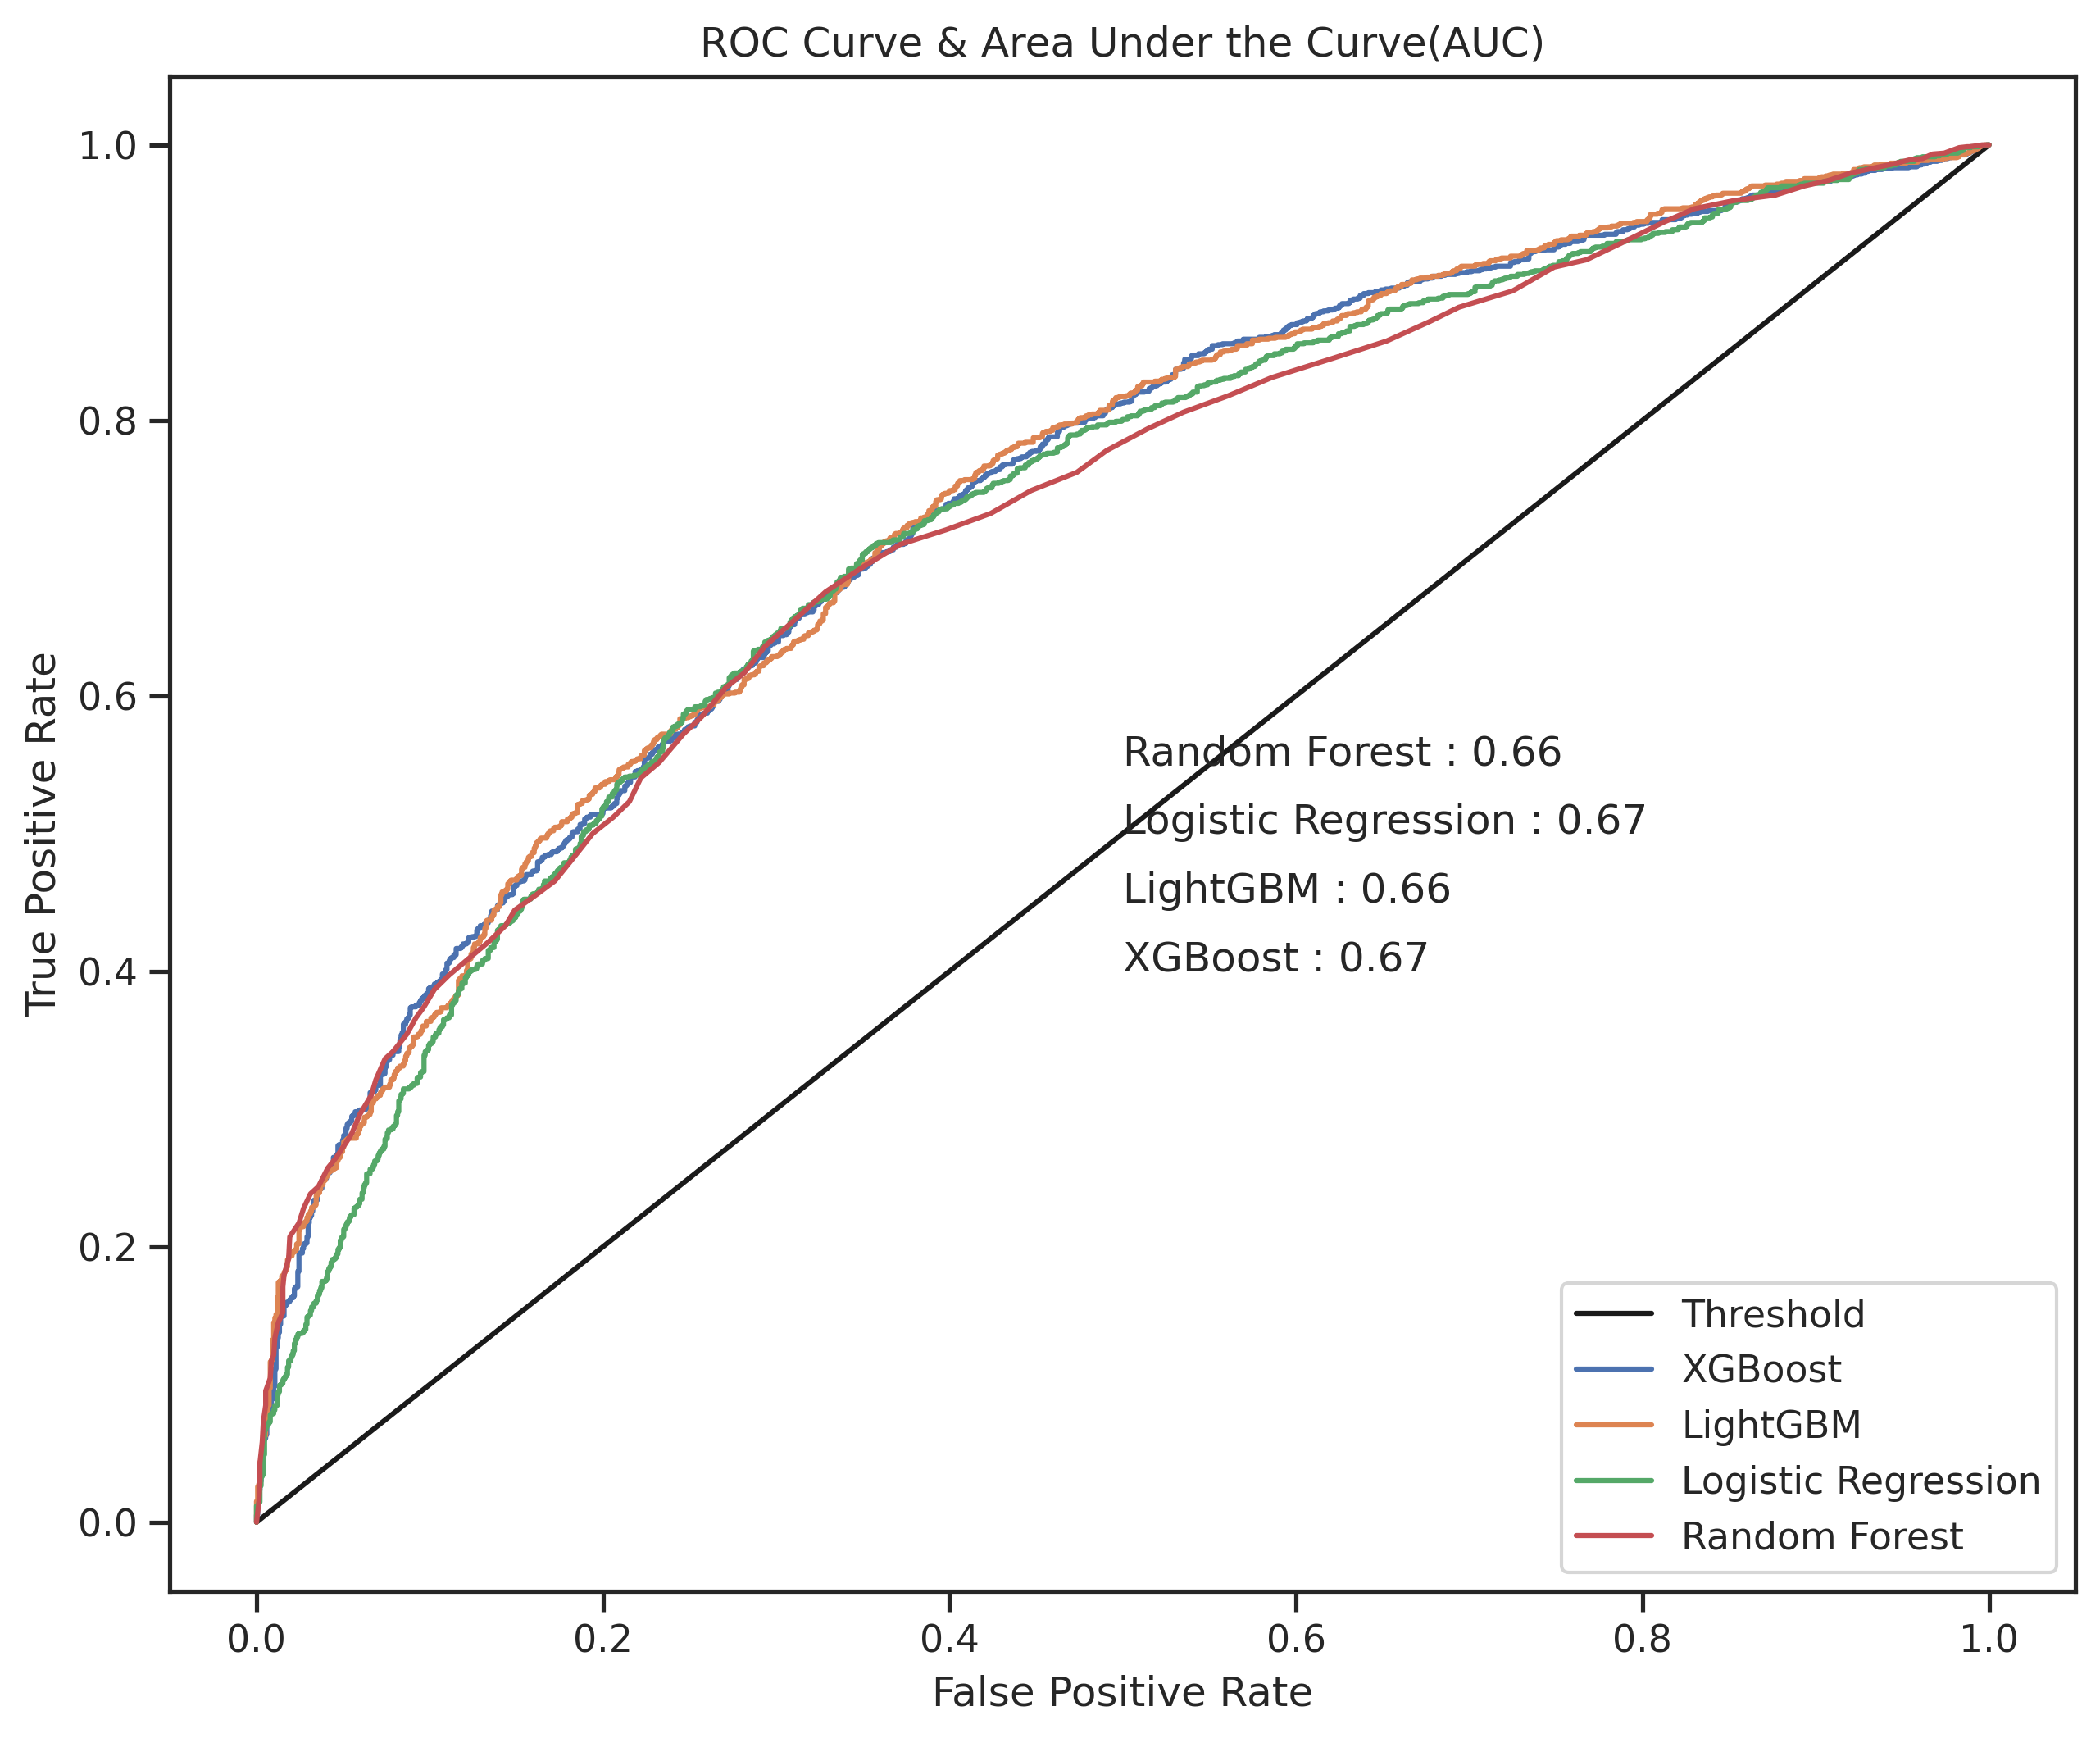

In [ ]:
# check roc, auc
# roc
from sklearn.metrics import roc_auc_score, roc_curve
def ROC(model, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    pred_positive_label = model.predict_proba(X_test)[:,1]
    fprs, tprs, thresholds = roc_curve(y_test, pred_positive_label)
    auc_score = roc_auc_score(y_test, y_pred)
    return fprs, tprs, thresholds, auc_score

# Ploting
plt.figure(figsize=(10, 8))
plt.plot([0,1], [0,1], label = 'Threshold', color = 'k')
i = 0
for model_name, model in models.items():
    fprs, tprs, thresholds, auc_score = ROC(model, X_test, y_test)
    plt.text(0.5,0.4+i*0.05, f'{model_name} : {round(auc_score,2)}')
    plt.plot(fprs, tprs, label=model_name)
    i+=1

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve & Area Under the Curve(AUC)')

plt.legend(loc = 'lower right')
plt.show()

현재 모델 : XGBoost
현재 진행도 : 0%
현재 진행도 : 1%
현재 진행도 : 2%


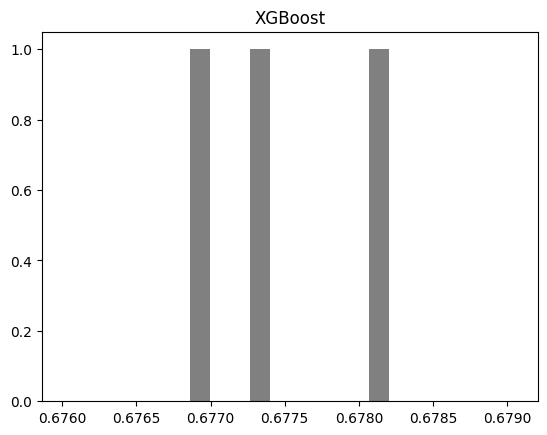

현재 모델 : LightGBM
현재 진행도 : 0%
현재 진행도 : 1%
현재 진행도 : 2%


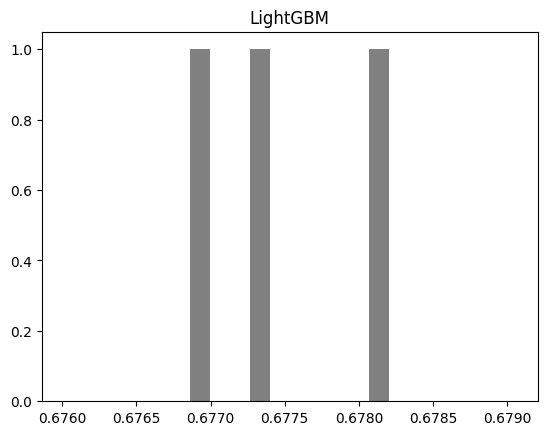

현재 모델 : Logistic Regression
현재 진행도 : 0%
현재 진행도 : 1%
현재 진행도 : 2%


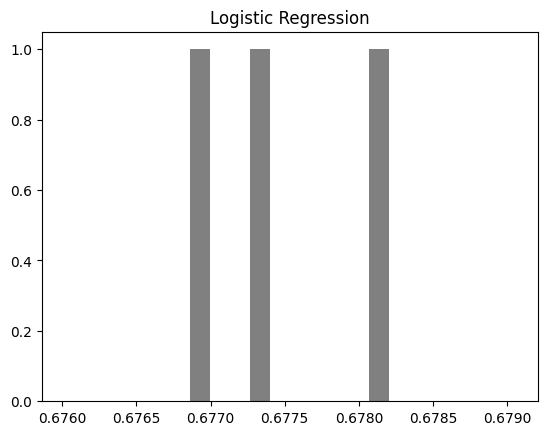

현재 모델 : Random Forest
현재 진행도 : 0%
현재 진행도 : 1%
현재 진행도 : 2%


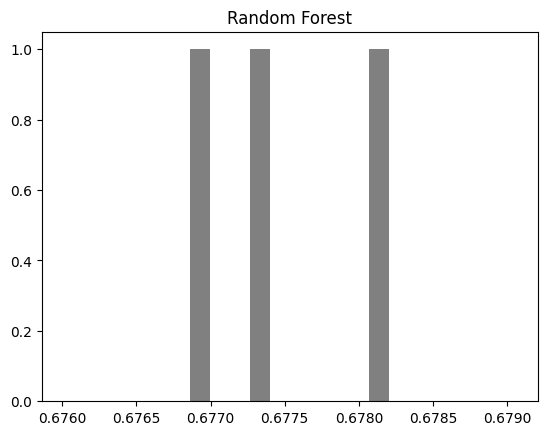

In [ ]:
# 5-fold cv
from sklearn.model_selection import cross_val_score
for model_name, model in models.items():
    print(f'현재 모델 : {model_name}')
    result_cv = []
    for i in range(100):
        print(f'현재 진행도 : {i}%')
        model = RandomForestClassifier(n_estimators=100,
                                  max_depth=10,
                                  random_state = i)
        model.fit(X_train, y_train)

        # 5-fold cv
        cv_5 = cross_val_score(model, X, y, cv=5, scoring='f1_macro')
        result_cv.append(cv_5.tolist())
        #if i == 2:
        #    break

    # dataframe
    df_cv = pd.DataFrame(result_cv, columns = ['cv1', 'cv2', 'cv3', 'cv4', 'cv5'])
    df_cv['avg_cv'] = df_cv.mean(axis = 1)
    # save
    df_cv.to_csv(f'{model_name}.csv', index = False)

    # Ploting
    plt.hist(df_cv['avg_cv'], color = 'grey', bins = 10)
    plt.xlim(df_cv['avg_cv'].min()-0.001, df_cv['avg_cv'].max()+0.001)
    plt.title(model_name)
    plt.show() 
